# Lab4: Case Study

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.skbn as skbn
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

In [3]:
df = pd.read_csv("./hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# Total stay in nights
df['total_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

# Total number of guests
df['guests'] = df['adults'] + df['children'] + df['babies']

# Creating the different_room_assigned feature
df['different_room_assigned'] = 0
slice_indices = df['reserved_room_type'] != df['assigned_room_type']
df.loc[slice_indices,'different_room_assigned'] = 1

# Deleting older features
df = df.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children',
                   'babies','reserved_room_type','assigned_room_type'],axis=1)

df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [5]:
print(f"Number of Null entries: {df.isnull().sum()}")
df = df.drop(['agent','company'],axis=1)

# Replacing missing countries with most freqently occuring countries
df['country']= df['country'].fillna(df['country'].mode()[0])
df['guests']= df['guests'].fillna(df['guests'].mode()[0]).astype(int)

df = df.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
df = df.drop(['arrival_date_year'],axis=1)
df = df.drop(['distribution_channel'], axis=1)

Number of Null entries: hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status               

In [6]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
df['different_room_assigned']= df['different_room_assigned'].replace(1,True)
df['different_room_assigned']= df['different_room_assigned'].replace(0,False)
df['is_canceled']= df['is_canceled'].replace(1,True)
df['is_canceled']= df['is_canceled'].replace(0,False)
df.dropna(inplace=True)
print(df.columns)
df.iloc[:, 5:20].head()

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.0,0,0,0,2
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.0,0,0,0,2
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.0,0,0,1,1
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.0,0,0,1,1
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.0,0,1,2,2


In [7]:
df = df[df.deposit_type=="No Deposit"]
df.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  arrival_date_month  \
deposit_type is_canceled                                         
No Deposit   False        74947      74947               74947   
             True         29694      29694               29694   

                          arrival_date_week_number   meal  country  \
deposit_type is_canceled                                             
No Deposit   False                           74947  74947    74947   
             True                            29694  29694    29694   

                          market_segment  is_repeated_guest  \
deposit_type is_canceled                                      
No Deposit   False                 74947              74947   
             True                  29694              29694   

                          previous_cancellations  \
deposit_type is_canceled                           
No Deposit   False                         74947   
             True                          29694   

                          previous_bookings_not_canceled  booking_changes  \
deposit_type is_canceled                                                    
No Deposit   False                                 74947            74947   
             True                                  29694            29694   

                          days_in_waiting_list  customer_type    adr  \
deposit_type is_canceled                                               
No Deposit   False                       74947          74947  74947   
             True                        29694          29694  29694   

                          required_car_parking_spaces  \
deposit_type is_canceled                                
No Deposit   False                              74947   
             True                               29694   

                          total_of_special_requests  total_stay  guests  \
deposit_type is_canceled                                                  
No Deposit   False                            74947       74947   74947   
             True                             29694       29694   29694   

                          different_room_assigned  
deposit_type is_canceled                           
No Deposit   False                          74947  
             True                           29694

In [8]:
df_copy = df.copy(deep=True)

In [9]:
counts_sum=0
for i in range(1,10):
        counts_i = 0
        rdf = df.sample(1000)
        counts_i = rdf[rdf["is_canceled"] == rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

0.5311

In [10]:
# Expected Count when there are no booking changes 
counts_sum=0
for i in range(1,10):
        counts_i = 0
        rdf = df[df["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

0.5163

In [11]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,10):
        counts_i = 0
        rdf = df[df["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

0.5943

In [12]:
df = df.drop(columns=["customer_type", "arrival_date_month", "arrival_date_week_number", "adr", "previous_cancellations", "deposit_type"])

# BN Prep

In [13]:
for var in df.select_dtypes(include='number').columns:
    print(var, df[var].nunique())

lead_time 431
is_repeated_guest 2
previous_bookings_not_canceled 73
booking_changes 21
days_in_waiting_list 99
required_car_parking_spaces 5
total_of_special_requests 6
total_stay 45
guests 15


In [14]:
disc = skbn.BNDiscretizer(defaultNumberOfBins=5, defaultDiscretizationMethod="kmeans")

#disc.setDiscretizationParameters(variableName="lead_time", method="quantile")
#disc.setDiscretizationParameters(variableName="is_repeated_guest", method="NoDiscretization")
disc.setDiscretizationParameters(variableName="previous_bookings_not_canceled", method="kmeans")
disc.setDiscretizationParameters(variableName="booking_changes", method="kmeans", paramDiscretizationMethod=5)
disc.setDiscretizationParameters(variableName="days_in_waiting_list", method="kmeans", paramDiscretizationMethod=5)

disc.setDiscretizationParameters(variableName="guests", method="kmeans", paramDiscretizationMethod=5)


#disc.setDiscretizationParameters(variableName="total_stay", method="quantile")


template = disc.discretizedBN(df)

In [15]:
template.variable("guests")

(pyAgrum.DiscreteVariable@0x60a0f639b7c0) guests:Discretized(<(0;7.9932[,[7.9932;20.1429[,[20.1429;33.1429[,[33.1429;46.25[,[46.25;55)>)

In [16]:
template.addArc("market_segment", "lead_time")
template.addArc("lead_time", "is_canceled")
template.addArc("country", "lead_time")
template.addArc("different_room_assigned", "is_canceled")
template.addArc("country", "meal")
template.addArc("lead_time", "days_in_waiting_list")
template.addArc("days_in_waiting_list", "is_canceled")
template.addArc("days_in_waiting_list", "different_room_assigned")
template.addArc("previous_bookings_not_canceled", "is_canceled")
template.addArc("previous_bookings_not_canceled", "is_repeated_guest")
template.addArc("is_repeated_guest", "different_room_assigned")
template.addArc("is_repeated_guest", "is_canceled")
template.addArc("total_stay", "is_canceled")
template.addArc("guests", "is_canceled")
template.addArc("booking_changes", "different_room_assigned")
template.addArc("booking_changes", "is_canceled")
template.addArc("hotel", "different_room_assigned")
template.addArc("hotel", "is_canceled")
template.addArc("required_car_parking_spaces", "is_canceled")
template.addArc("total_of_special_requests", "booking_changes")
template.addArc("total_of_special_requests", "is_canceled")
template.addArc("country", "hotel")
template.addArc("country", "required_car_parking_spaces")
template.addArc("country", "total_of_special_requests")
template.addArc("market_segment", "hotel")
template.addArc("market_segment", "required_car_parking_spaces")
template.addArc("market_segment", "total_of_special_requests")

In [17]:
learner = gum.BNLearner(df, template)
learner.useNMLCorrection()
learner.useSmoothingPrior(1e-9)

bn = gum.BayesNet(template)
learner.fitParameters(bn)

(pyAgrum.BNLearner<double>@0x60a0fa0e6490) Filename       : /tmp/tmp472rps6a.csv
Size           : (104641,15)
Variables      : hotel[2], is_canceled[2], lead_time[5], meal[5], country[177], market_segment[8], is_repeated_guest[2], previous_bookings_not_canceled[5], booking_changes[5], days_in_waiting_list[5], required_car_parking_spaces[5], total_of_special_requests[6], total_stay[5], guests[5], different_room_assigned[2]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000000

In [18]:
cslbn = csl.CausalModel(bn, [("U", ["total_of_special_requests", "required_car_parking_spaces", "total_stay", "guests"])])

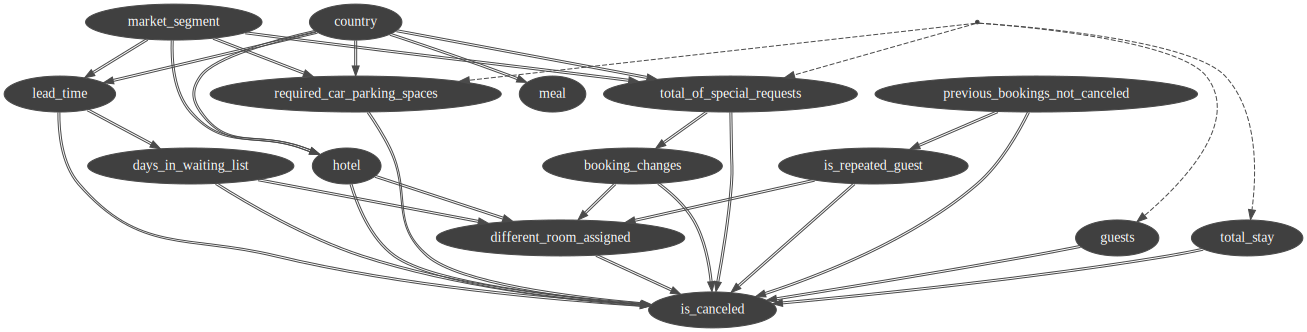

In [19]:
cslnb.showCausalModel(cslbn, size="50")

In [20]:
T = "different_room_assigned"
Y = "is_canceled"

In [21]:
cslnb.showCausalImpact(cslbn, doing=T, on=Y, values={T:1})

In [22]:
cslnb.showCausalImpact(cslbn, doing=T, on=Y, values={T:0})

In [23]:
_, cpt0, _ = csl.causalImpact(cslbn, on=Y, doing=T, values={T:0})
_, cpt1, _ = csl.causalImpact(cslbn, on=Y, doing=T, values={T:1})
diff = cpt1 - cpt0
diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))

-0.2593759577130329

In [24]:
gnb.showInformation(bn, size="50")

[pyAgrum] pyAgrum.lib.notebook.showInformation is deprecated since 0.20.2. Please use pyAgrum.lib.explain.showInfomation instead.


In [25]:
csl.doCalculusWithObservation(cslbn, on={Y}, doing={T}, knowing={"hotel"})

$P( is_canceled \mid \text{do}(different_room_assigned), hotel) = \frac {\sum_{booking_changes,country,days_in_waiting_list,guests,is_repeated_guest,lead_time,market_segment,previous_bookings_not_canceled,required_car_parking_spaces,total_of_special_requests,total_stay}{P\left(total_stay\right) \cdot P\left(guests\mid total_stay\right) \cdot P\left(total_of_special_requests\mid country,guests,market_segment,required_car_parking_spaces,total_stay\right) \cdot P\left(required_car_parking_spaces\mid country,guests,market_segment,total_stay\right) \cdot P\left(days_in_waiting_list\mid lead_time\right) \cdot P\left(booking_changes\mid total_of_special_requests\right) \cdot P\left(previous_bookings_not_canceled\right) \cdot P\left(is_repeated_guest\mid previous_bookings_not_canceled\right) \cdot P\left(market_segment\right) \cdot P\left(country\right) \cdot P\left(lead_time\mid country,market_segment\right) \cdot P\left(is_canceled\mid booking_changes,days_in_waiting_list,different_room_assigned,guests,hotel,is_repeated_guest,lead_time,previous_bookings_not_canceled,required_car_parking_spaces,total_of_special_requests,total_stay\right) \cdot P\left(hotel\mid country,market_segment\right)}}{P\left(hotel\right)}$

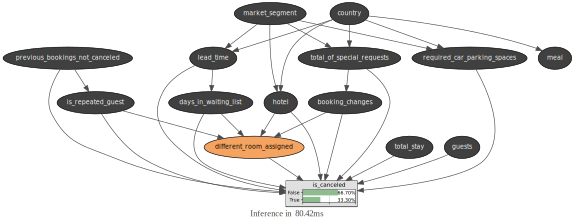

In [26]:
gnb.showInference(bn, evs={T:0}, targets={Y})

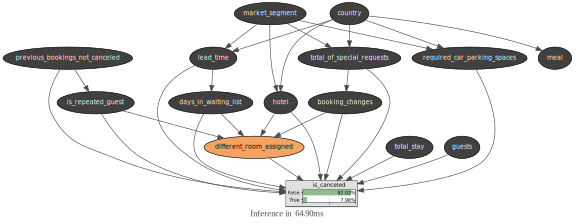

In [27]:
gnb.showInference(bn, evs={T:1}, targets={Y})

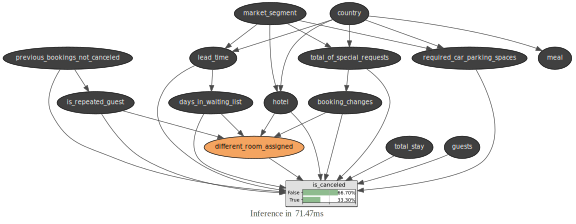

In [28]:
gnb.showInference(bn, evs={T:0}, targets={Y})

In [29]:
#observational
ie = gum.LazyPropagation(bn)

ie.setEvidence({T: 0})
ie.makeInference()
p0 = ie.posterior(Y)

ie.chgEvidence(T,1)
ie.makeInference()
p1 = ie.posterior(Y)

diff = p1 - p0
diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))

-0.2531514972542681

In [30]:
def mutilateBN(bn : gum.BayesNet) -> gum.BayesNet:
    """
    Returns a copy of the Bayesian Network with all incoming arcs to the variable T removed.
    """
    res = gum.BayesNet(bn)
    for p_id in bn.parents(T):
        res.eraseArc(p_id, bn.idFromName(T))
    return res

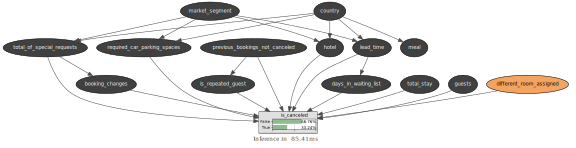

In [31]:
gnb.showInference(mutilateBN(bn), evs={T:0}, targets={Y})

In [32]:
gum.lib.explain.showInformation(mutilateBN(bn), size="50")

In [33]:
#interventional
ie = gum.LazyPropagation(mutilateBN(bn))

ie.setEvidence({T: 0})
ie.makeInference()
p0 = ie.posterior(Y)

ie.chgEvidence(T,1)
ie.makeInference()
p1 = ie.posterior(Y)

diff = p1 - p0
diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))

-0.259375957713033

In [34]:
#X = {"days_in_waiting_list": 4}
#X = {"guests": 4}
#X = {"is_repeated_guest":1}
#X = {"total_stay":4}
X = {"lead_time":1}

In [35]:
def ATE(bn, X):
    ie = gum.LazyPropagation(mutilateBN(bn))

    ie.setEvidence({T: 0} | X)
    ie.makeInference()
    p0 = ie.posterior(Y)

    ie.chgEvidence(T,1)
    ie.makeInference()
    p1 = ie.posterior(Y)

    diff = p1 - p0
    return diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))

In [36]:
ie = gum.LazyPropagation(mutilateBN(bn))

ie.setEvidence({T: 1}|X)
ie.makeInference()
p0 = ie.posterior(Y)
p0

(pyAgrum.Potential<double>@0x60a0fbe80fd0) 
  is_canceled      |
False    |True     |
---------|---------|
 0.9355  | 0.0645  |

In [45]:
bn.variable("lead_time").domainSize()

5

In [46]:
def cond_ATE_evo(bn, target):
    ate_list = list()
    for i in range(bn.variable(target).domainSize()):
        ate_list.append(ATE(bn, {target:i}))
    return ate_list

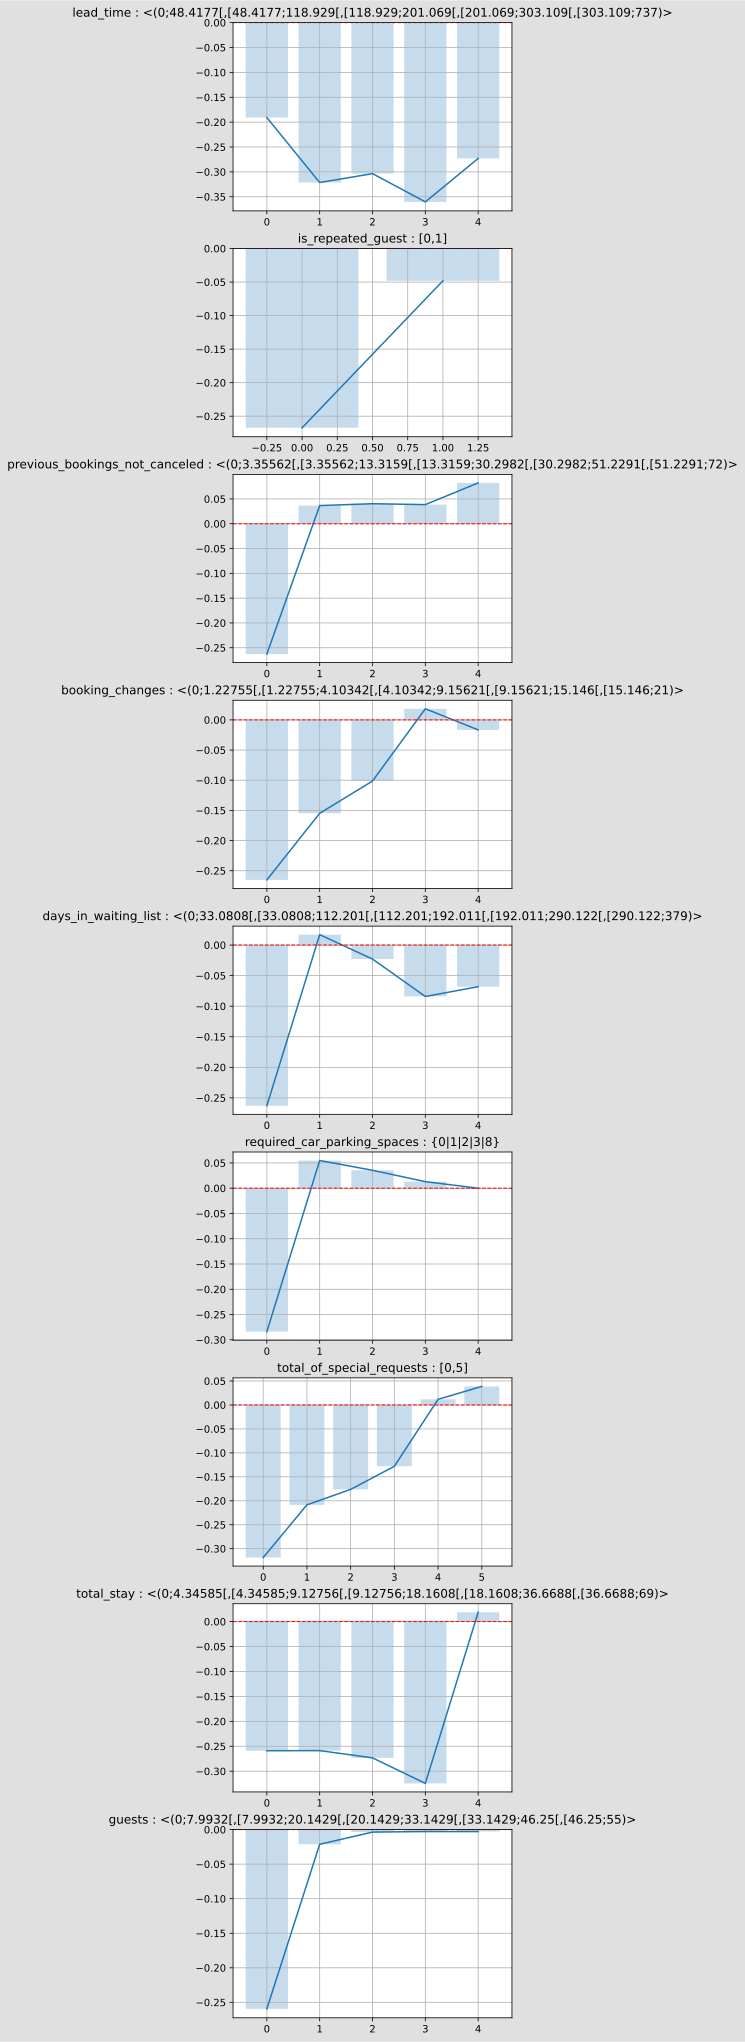

In [57]:
#covar_list = ["days_in_waiting_list", "lead_time", "is_repeated_guest", "is_repeated_guest", "total_stay"]
covar_list = df.select_dtypes(include='number').columns

plt.subplots(figsize=(5,4*len(covar_list)))

for i in range(len(covar_list)):

    plt.subplot(len(covar_list), 1, i+1)

    plt.bar(range(bn.variable(covar_list[i]).domainSize()), cond_ATE_evo(bn, covar_list[i]), alpha=0.25)
    plt.plot(range(bn.variable(covar_list[i]).domainSize()), cond_ATE_evo(bn, covar_list[i]))
    plt.grid(True)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
    plt.title(f"{covar_list[i]} : {bn.variable(covar_list[i]).domain()}")

In [63]:
country_list = df["country"].unique()
ATE_country_list = list() 
for country in country_list:
    ATE_country_list.append(ATE(bn, {"country":country}))
    

<BarContainer object of 177 artists>

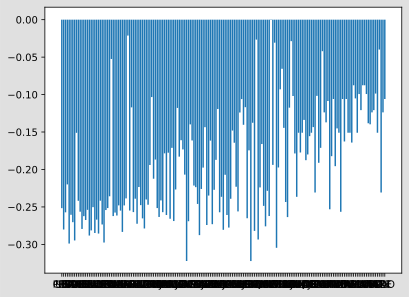

In [64]:
plt.bar(country_list, ATE_country_list)

In [69]:
market_seg_list = df["market_segment"].unique()
ATE_market_seg__list = list() 
for seg in market_seg_list:
    ATE_market_seg__list.append(ATE(bn, {"market_segment":seg}))
    

<BarContainer object of 8 artists>

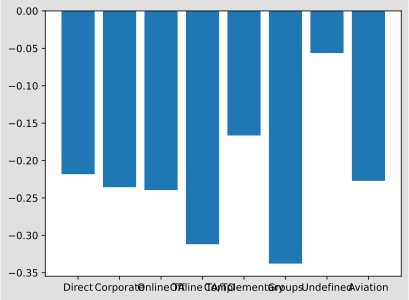

In [70]:
plt.bar(market_seg_list, ATE_market_seg__list)

In [71]:
hotel_list = df["hotel"].unique()
ATE_hotel_list = list() 
for hotel in hotel_list:
    ATE_hotel_list.append(ATE(bn, {"hotel":hotel}))
    

<BarContainer object of 2 artists>

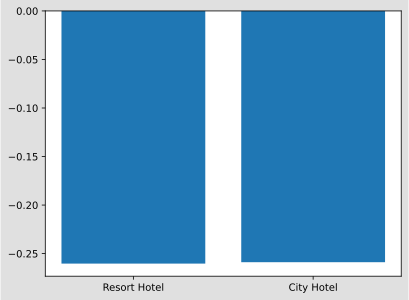

In [72]:
plt.bar(hotel_list, ATE_hotel_list)